In [1]:
# Step 1: Load UCI Heart Disease dataset (Cleveland) from UCI repository and inspect head
import pandas as pd
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
# Column names based on UCI documentation
col_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
             'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
df_heart = pd.read_csv(url, names=col_names)
# Show head and count of missing values
print(df_heart.head())
print('\
Missing value counts:')
print(df_heart.isin(['?']).sum())
print('done')



    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  target  
0    3.0  0.0  6.0       0  
1    2.0  3.0  3.0       2  
2    2.0  2.0  7.0       1  
3    3.0  0.0  3.0       0  
4    1.0  0.0  3.0       0  
Missing value counts:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64
done


In [2]:
# Cleaning missing values: replace '?' with NaN, convert columns to numeric, drop missing rows
import numpy as np
# Replace '?'
df_clean = df_heart.replace('?', np.nan)
# Convert ca, thal to numeric
df_clean['ca'] = pd.to_numeric(df_clean['ca'], errors='coerce')
df_clean['thal'] = pd.to_numeric(df_clean['thal'], errors='coerce')
# Drop rows with NaN
df_clean = df_clean.dropna()
# Show head and missing counts after cleaning
print(df_clean.head())
print('\
Missing value counts after cleaning:')
print(df_clean.isnull().sum())
print('done')


    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  
Missing value counts after cleaning:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
done


In [3]:
# Step 3: Split cleaned data into train (80%) and test (20%)
from sklearn.model_selection import train_test_split
# Features and target
df_clean['target'] = df_clean['target'].apply(lambda x: 1 if x > 0 else 0)  # binary classification: presence vs absence
X = df_clean.drop(columns=['target'])
y = df_clean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print('Training set size:', X_train.shape)
print('Test set size:', X_test.shape)
print('done')



Training set size: (237, 13)
Test set size: (60, 13)
done


                  Accuracy  Precision  Recall  F1-score  AUC-ROC
Model                                                           
SVM                  0.900      0.846   0.917     0.880    0.933
GradientBoosting     0.817      0.741   0.833     0.784    0.912
RandomForest         0.867      0.864   0.792     0.826    0.934


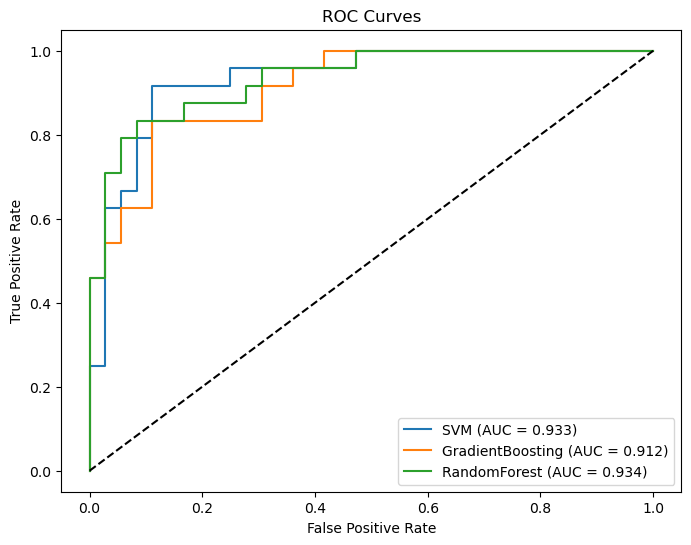

done


In [4]:
# Step 4: Hyperparameter tuning and model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define models and hyperparameter grids
grid_params = {
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [50, 100], 'max_depth': [None, 5]}
    }
}

results = []
best_models = {}

for name, gp in grid_params.items():
    clf = GridSearchCV(gp['model'], gp['params'], cv=5, scoring='roc_auc')
    clf.fit(X_train, y_train)
    best = clf.best_estimator_
    best_models[name] = best
    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)[:,1]
    # compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results.append({'Model': name,
                    'Accuracy': round(acc, 3),
                    'Precision': round(prec, 3),
                    'Recall': round(rec, 3),
                    'F1-score': round(f1, 3),
                    'AUC-ROC': round(auc, 3)})

# Summary table
df_results = pd.DataFrame(results).set_index('Model')
print(df_results)

# Plot ROC curves
plt.figure(figsize=(8,6))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name + ' (AUC = ' + str(round(roc_auc_score(y_test, y_proba),3)) + ')')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

print('done')